In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, LSTM, Embedding, Concatenate, Reshape, Add, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

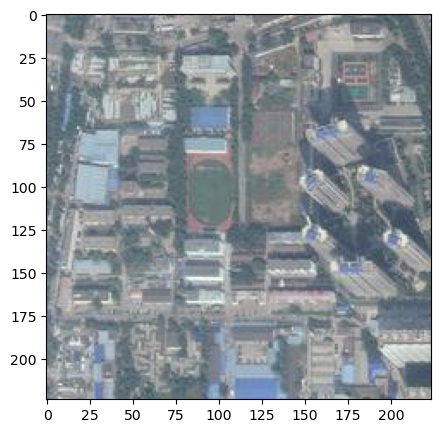

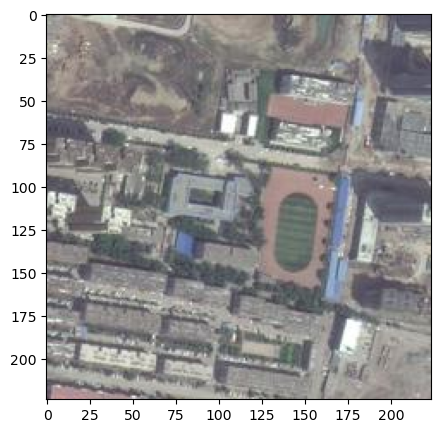

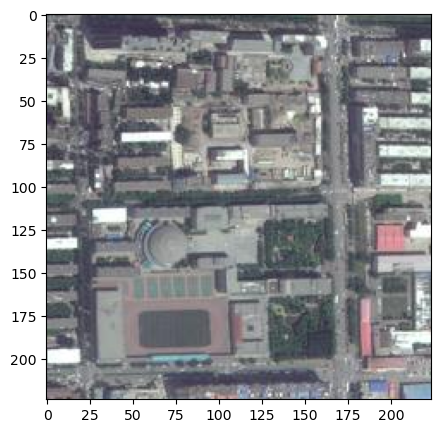

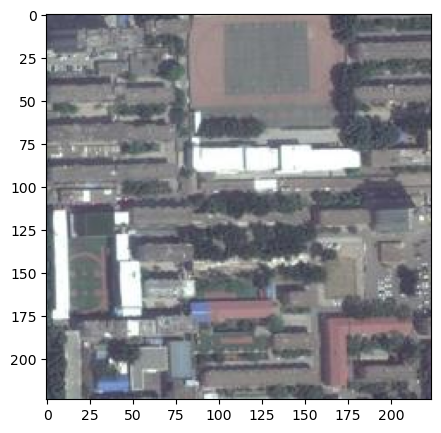

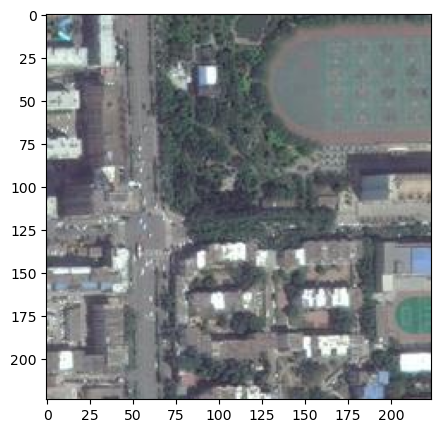

In [2]:
# Load images
img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images"
images = glob(img_path + '\\*.jpg')

# Load captions
captions = open(r"C:\Users\SRAVAN\Downloads\outcap.txt", 'rb').read().decode('utf-8').split('\n')
captions = [line.replace('\r', '') for line in captions]

# Display sample images
for i in range(5):
    plt.figure(figsize=(5,5))
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [3]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model

# Load DenseNet201 model
densenet_model = DenseNet201(include_top=True, weights='imagenet')

# Remove classification layer
densenet_features_model = Model(inputs=densenet_model.input, outputs=densenet_model.layers[-2].output)


In [4]:
# Extract image features using MobileNetV2
count=0
img_features = {}
for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) 
    img = img.reshape(1,224,224,3) 
    features =densenet_features_model.predict(img).reshape(-1,) 
    img_name = img_path.split('/')[-1] 
    img_features[img_name] = features
    count += 1
    # Fetching the features of only 1500 images as using more than 1500 images leads to overloading memory issues
    if count == 2000:
        break
    if count % 50 == 0:
        print(count)

  0%|          | 0/10921 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [5]:
len(img_features)

2000

In [6]:
captions = captions[1:]
captions[:5]

['00001.jpg,a football field with several buildiings surroudned .',
 '00001.jpg,a rectangular playground and many tall buildings surrounded .',
 '00001.jpg,many buildings and green trees are around a playground .',
 '00001.jpg,many buildings are in different blocks with many green trees and a playground .',
 '00001.jpg,a playground is surrounded by many trees and buildings .']

In [7]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        img_name = "C:\\Users\\SRAVAN\\Downloads\\RSICD_images\\RSICD_images\\" + img_name # Adding the prefix
        caption = cap.split(',')[1]
        
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions 
    except:
        break

print(len(captions_dict))


2000


In [8]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [9]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

In [10]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [11]:
len(count_words) # Vocab size

1455

In [12]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [13]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [14]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

1455

In [15]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []
    
    for key, val in caption.items(): 
        for item in val: 
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word 
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    
    return X, y_input, y_output

In [16]:
X, y_in, y_out = generator(img_features,captions_dict)

In [17]:
len(X), len(y_in), len(y_out)

(125613, 125613, 125613)

In [18]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [19]:
X.shape, y_in.shape, y_out.shape

((125613, 1920), (125613, 35), (125613, 1456))

In [20]:
from keras.layers import Layer, Reshape, add

class CaptionsModel(Layer):
    def __init__(self, vocab_size, embedding_len, max_len):
        super(CaptionsModel, self).__init__()
        self.embedding = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=False)  # Adjust embedding output_dim
        self.lstm = LSTM(256)
        self.vocab_size = vocab_size

    def call(self, inputs):
        img_features, sentence_features = inputs
        embeddings = self.embedding(sentence_features)
        merged = Concatenate(axis=1)([img_features, embeddings])
        lstm_output = self.lstm(merged)
        return lstm_output

vocab_size = len(count_words)
max_length = max_len

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256))(img_features)

captions_model = CaptionsModel(vocab_size, 256, max_length)
sentence_features = captions_model([img_features_reshaped, input2])

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(units=1456, activation='softmax')(x)# Adjust units parameter
  

final_model = Model(inputs=[input1, input2], outputs=output)
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
final_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 1920)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         491,776 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 1, 256)            │               0 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_2 (InputLayer)    │ (None, 35)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ captions_model                │ (None, 256)               │         897,792 │ reshape[0][0],             │
│ (CaptionsModel)               │                           │                 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 256)               │               0 │ captions_model[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dropout[0][0], dense[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 128)               │          32,896 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 128)               │               0 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1456)              │         187,824 │ dropout_1[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,610,288 (6.14 MB)

 Trainable params: 1,610,288 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
from sklearn.model_selection import train_test_split

# Splitting data into train, validation, and test sets
X_train, X_temp, y_in_train, y_in_temp, y_out_train, y_out_temp = train_test_split(X, y_in, y_out, test_size=0.6, random_state=42)
X_val, X_test, y_in_val, y_in_test, y_out_val, y_out_test = train_test_split(X_temp, y_in_temp, y_out_temp, test_size=0.5, random_state=42)

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define ModelCheckpoint callback to save the best model based on validation accuracy
mc1 = ModelCheckpoint(r"C:\Users\SRAVAN\Downloads\dense.keras", monitor='accuracy', verbose=1, mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)


# Compile the model with accuracy metric
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model without EarlyStopping callback
history = final_model.fit([X_train, y_in_train],
                          y_out_train,
                          batch_size=128,
                          callbacks=[mc1,es],  # Remove EarlyStopping callback here
                          epochs=50,
                          validation_data=([X_val, y_in_val], y_out_val))

# Print loss, validation loss, and validation accuracy for each epoch
for epoch, metrics in enumerate(zip(history.history['loss'], history.history['val_loss'], history.history['val_accuracy'])):
    print(f"Epoch {epoch + 1}: loss: {metrics[0]:.4f} - val_loss: {metrics[1]:.4f} - val_accuracy: {metrics[2]:.4f}")


Epoch 1/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.0771 - loss: 4.8082
Epoch 1: accuracy improved from -inf to 0.11122, saving model to C:\Users\SRAVAN\Downloads\dense.keras
393/393 ━━━━━━━━━━━━━━━━━━━━ 257s 244ms/step - accuracy: 0.0772 - loss: 4.8070 - val_accuracy: 0.1587 - val_loss: 3.8857
Epoch 2/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.1510 - loss: 3.9124
Epoch 2: accuracy improved from 0.11122 to 0.15301, saving model to C:\Users\SRAVAN\Downloads\dense.keras
393/393 ━━━━━━━━━━━━━━━━━━━━ 69s 176ms/step - accuracy: 0.1510 - loss: 3.9123 - val_accuracy: 0.1613 - val_loss: 3.7788
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1533 - loss: 3.7995
Epoch 3: accuracy did not improve from 0.15301
393/393 ━━━━━━━━━━━━━━━━━━━━ 70s 177ms/step - accuracy: 0.1533 - loss: 3.7995 - val_accuracy: 0.1612 - val_loss: 3.7635
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1561 - loss: 3.7533
Epoch 4: accuracy improved from

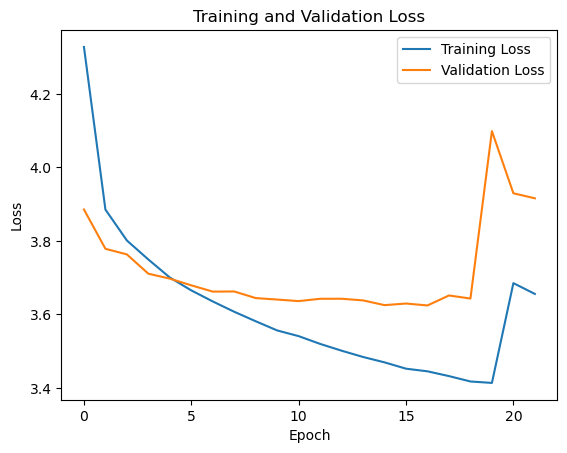

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
def calculate_accuracy(model, X, y_in, y_out):
    predictions = model.predict([X, y_in])
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(y_out, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

# Calculate accuracy on validation set
val_accuracy = calculate_accuracy(final_model, X_val, y_in_val, y_out_val)
print("Validation Accuracy:", val_accuracy)

# Calculate accuracy on test set
test_accuracy = calculate_accuracy(final_model, X_test, y_in_test, y_out_test)
print("Test Accuracy:", test_accuracy)

1178/1178 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step
Validation Accuracy: 0.15919223012419065
1178/1178 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step
Test Accuracy: 0.1571223861585819


In [25]:
# Extracting training metrics
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Extracting validation metrics
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Evaluating metrics on test set
test_loss, test_accuracy = final_model.evaluate([X_test, y_in_test], y_out_test, verbose=0)

# Printing metrics
print("Train Accuracy:", train_accuracy[-1])
print("Train Loss:", train_loss[-1])
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)
print("Validation Accuracy:", val_accuracy[-1])
print("Validation Loss:", val_loss[-1])

Train Accuracy: 0.08275450021028519
Train Loss: 3.6559348106384277
Test Accuracy: 0.1571223884820938
Test Loss: 3.631378412246704
Validation Accuracy: 0.084385946393013
Validation Loss: 3.916137218475342


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Make predictions on the test set
y_pred = final_model.predict([X_test, y_in_test])

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_out_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)
recall = recall_score(y_true_classes, y_pred_classes, average='macro', zero_division=1)

f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
# Print evaluation metrics
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

1178/1178 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step
Test Accuracy: 0.1571223884820938
Precision: 0.964790116512001
Recall: 0.003562983720418725
F1 Score: 0.0027766621861070482


In [27]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

In [28]:
final_model.save('densenet_201.keras')

In [29]:
np.save('vocab.npy',count_words)

In [30]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

In [31]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\train\00658.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = "two big playground and a small playground are surrounded by many buildings ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


Image path 'C:\Users\SRAVAN\Downloads\RSICD_images\train\00658.jpg' not found in the images list.


NameError: name 'image_index' is not defined

In [ ]:
#airport_318.jpg,a large number of cars parked near the airport plains .


from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\baseballfield_6.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = "a baseball field is near several green trees ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


In [ ]:
#bareland_132.jpg,it is a large piece of yellow bareland .



from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\00086.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption ="a playground is surroundeded by many tall buildings ."


# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


In [ ]:
#bareland_145.jpg,some green trees and several business are around a bareland .




from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\bareland_145.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = "some green trees and several business are around a bareland ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


In [ ]:
#beach_108.jpg,white waves are near yellow beach and green ocean .


from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\airport_245.jpg" # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = "many white planes are near a terminal in an airport ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


In [ ]:
#beach_108.jpg,white waves are near yellow beach and green ocean .


from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\baseballfield_45.jpg" # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = "the brown land is a baseball field ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


In [ ]:
#beach_108.jpg,white waves are near yellow beach and green ocean .


from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\beach_37.jpg" # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = "some trees are planted on the beach ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


In [ ]:
# "C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\beach_48.jpg"




from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\beach_6.jpg" # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = "a piece of green ocean is near a yellow beach with two buildings ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


In [ ]:
# "C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\bridge_15.jpg"




from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\bridge_14.jpg" # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption =r"a bridge is on a river with several green trees near it ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


In [ ]:
# "C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\bridge_15.jpg"




from nltk.translate.bleu_score import sentence_bleu
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\bridge_20.jpg" # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = r"this is a big bridge and some buildings ."

# Calculate BLEU scores
real_tokens = real_caption.split()
pred_tokens = caption.split()
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption


In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Process only the first image (index 0)
test_img_path = r"C:\Users\SRAVAN\Downloads\RSICD_images\RSICD_images\airport_245.jpg"  # Example image path

# Find the index of the test_img_path in the images list
try:
    image_index = images.index(test_img_path)
except ValueError:
    print(f"Image path '{test_img_path}' not found in the images list.")
    # Handle the case where the image path is not found
    # You may want to exit the script or handle this scenario accordingly

# Load the image using the getImage function and image_index
test_feature = densenet_features_model.predict(getImage(image_index)).reshape(1, 1920)

# Load and preprocess the image using OpenCV
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Initialize the caption generation process
pred_text = ['startofseq']
count = 0
caption = ''  # Stores the predicted captions text

while count < 25:
    count += 1
    # Encoding the captions text with numbers
    encoded = [count_words[word] for word in pred_text]
    
    # Padding the encoded text sequences to maximum length
    encoded = pad_sequences([encoded], maxlen=max_len, padding='post', truncating='post')
    
    # Fetching the predicted word index
    pred_idx = np.argmax(final_model.predict([test_feature, encoded]))
    
    # Extracting the predicted word by its respective index
    sampled_word = inverse_dict[pred_idx]
    
    # Checking for ending of the sequence
    if sampled_word == 'endofseq':
        break
    caption = caption + ' ' + sampled_word
    pred_text.append(sampled_word)

# Construct the real caption (replace this with your real caption retrieval mechanism)
real_caption = read_captions(r"C:\Users\SRAVAN\Downloads\outcap.txt", "airport_245.jpg")
# Tokenize the real caption and predicted caption
real_tokens = word_tokenize(real_caption)
pred_tokens = word_tokenize(caption)

# Calculate BLEU scores
score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print(f"BLEU-1 score: {score_bleu1 * 100}")
print(f"BLEU-2 score: {score_bleu2 * 100}")
print(f"BLEU-3 score: {score_bleu3 * 100}")
print(f"BLEU-4 score: {score_bleu4 * 100}")

# Print real and predicted captions
print('Real Caption:', real_caption)
print('Predicted Caption:', caption)

# Display image with predicted caption
plt.figure(figsize=(5, 5))
plt.imshow(test_img)
plt.xlabel(caption)  # Show predicted caption as image label
plt.show()  # Show the image with the predicted caption

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Calculate ROUGE scores
scores_rouge = scorer.score(real_caption, caption)

# Print ROUGE scores
print('ROUGE Scores:', scores_rouge)

# Calculate METEOR score
score_meteor = meteor_score([real_tokens], pred_tokens)

# Print METEOR score
print(f"METEOR score: {score_meteor * 100}")

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming 'images' is a list of image paths and 'getImage' is a function to load an image
# 'count_words', 'max_len', 'final_model', 'resnet_features_model', 'inverse_dict' should be defined previously
# Read captions from the file
def read_captions(file_path, image_name):
    with open(file_path, 'r') as file:
        captions = file.readlines()
    for caption in captions:
        if caption.startswith(image_name):
            return caption.strip().split(',')[1]
    return None

# Initialize lists to store scores
bleu1_scores = []
bleu2_scores = []
bleu3_scores = []
bleu4_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
meteor_scores = []

for i in range(10):  # Change this to the number of iterations you want
    random_no = np.random.randint(0, 1501, (1, 1))[0, 0]
    test_feature = densenet_features_model.predict(getImage(random_no)).reshape(1, 1920)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    pred_text = ['startofseq']
    count = 0
    caption = ''  # Stores the predicted captions text

    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []

        for i in pred_text:
            encoded.append(count_words[i])

        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded, maxlen=max_len, padding='post', truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature, encoded]))  # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx]  # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)

    # Construct the real caption
    real_caption = read_captions(r"C:\Users\SRAVAN\Downloads\outcap.txt", test_img_path.split("\\")[-1])
    # Tokenize the real caption and predicted caption
    real_tokens = word_tokenize(real_caption)
    pred_tokens = word_tokenize(caption)
    
    # Calculate BLEU scores
    score_bleu1 = sentence_bleu([real_tokens], pred_tokens, weights=(1, 0, 0, 0))
    score_bleu2 = sentence_bleu([real_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0))
    score_bleu3 = sentence_bleu([real_tokens], pred_tokens, weights=(1 / 3, 1 / 3, 1 / 3, 0))
    score_bleu4 = sentence_bleu([real_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25))

    # Append BLEU scores to the lists
    bleu1_scores.append(score_bleu1)
    bleu2_scores.append(score_bleu2)
    bleu3_scores.append(score_bleu3)
    bleu4_scores.append(score_bleu4)
    
    # Initialize ROUGE scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    # Calculate ROUGE scores
    scores_rouge = scorer.score(real_caption, caption)
    # Append ROUGE scores to the lists
    rouge1_scores.append(scores_rouge['rouge1'][2])
    rouge2_scores.append(scores_rouge['rouge2'][2])
    rougeL_scores.append(scores_rouge['rougeL'][2])
    
    # Calculate METEOR score
    score_meteor = meteor_score([real_tokens], pred_tokens)
    # Append METEOR score to the list
    meteor_scores.append(score_meteor)

# Calculate the average scores
average_bleu1_score = np.mean(bleu1_scores)
average_bleu2_score = np.mean(bleu2_scores)
average_bleu3_score = np.mean(bleu3_scores)
average_bleu4_score = np.mean(bleu4_scores)
average_rouge1_score = np.mean(rouge1_scores)
average_rouge2_score = np.mean(rouge2_scores)
average_rougeL_score = np.mean(rougeL_scores)
average_meteor_score = np.mean(meteor_scores)

# Print the average scores
print(f"Average BLEU-1 score: {average_bleu1_score * 100}")
print(f"Average BLEU-2 score: {average_bleu2_score * 100}")
print(f"Average BLEU-3 score: {average_bleu3_score * 100}")
print(f"Average BLEU-4 score: {average_bleu4_score * 100}")
print(f"Average ROUGE-1 score: {average_rouge1_score * 100}")
print(f"Average ROUGE-2 score: {average_rouge2_score * 100}")
print(f"Average ROUGE-L score: {average_rougeL_score * 100}")
print(f"Average METEOR score: {average_meteor_score * 100}")